In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import G, M_sun, k_B, m_p
from scipy.interpolate import interp1d
from matplotlib import colors 
from scipy.integrate import simps
from scipy import interpolate
import astropy.units as u
import tqdm
import numpy as np
import warnings
import os
import sys

sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline
#from pipeline_stress import _fill_2Dhist
from pipeline_1D import *
from pipeline_stress import _fill_2Dhist

top = os.getenv('HOME')+'/codes/dispatch2/'
sys.path.insert(0,top+'utilities/python/dispatch/EOS')
from polytrope import polytrope



# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:19<00:00, 215.59it/s]


Converged mean angular momentum vector after 1 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 25302.72it/s]

Disk size: 17.9 au


Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:01<00:00, 3151.07it/s]


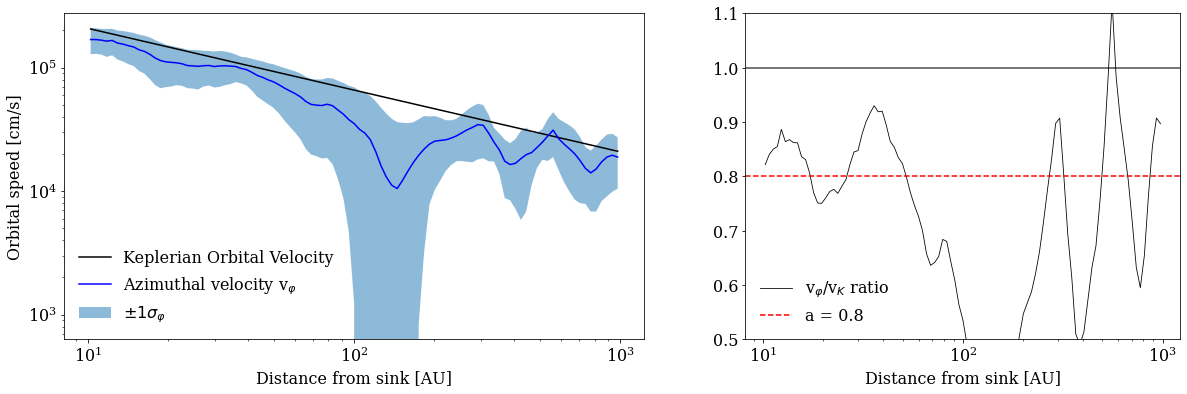

In [3]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = True); data.calc_trans_xyz()

### Find the lowest density value in your box, and ask what the temperature is. If it is ≈10 K, the black points are probably good


In [ ]:
lowest_patchval = np.zeros((len(data.sn.patches), 3))
for i, p in enumerate(data.sn.patches):
    idx = np.unravel_index(p.var('d').argmin(), p.var('d').shape)
    cs = np.sqrt(p.γ[idx] * p.var('pgas')[idx] / p.var('d')[idx])
    lowest_patchval[i] = cs * data.cms_velocity, p.γ[idx], p.var('d')[idx] * data.cgs_density

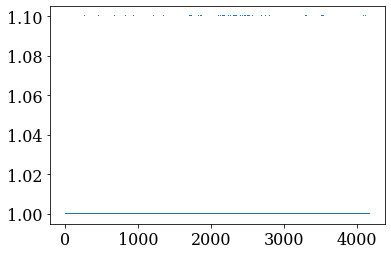

In [ ]:
plt.plot(lowest_patchval[:,1],',')

In [ ]:
μ = 2.34
lowest_temperature = lowest_patchval[:,0]**2 * μ * m_p.to('g').value / (lowest_patchval[:,1] *  k_B.to('erg/K').value)

In [ ]:
np.argmin(lowest_temperature), lowest_temperature.min(), lowest_patchval[:,2][2484]

(2484, 0.9184916242809522, 3.7005813152343754e-17)

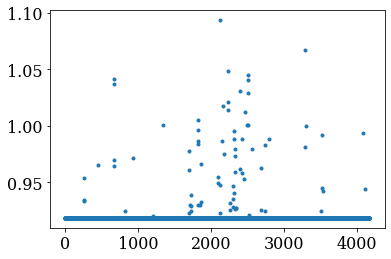

In [ ]:
plt.plot(lowest_temperature, '.')

In [ ]:
T=p.var(4)/p.var(0)*data.sn.scaling.temp*2.34

In [ ]:
poly = polytrope(unit_density =  data.cgs_density)

In [ ]:
poly.gamma(p.var('d')).std()

0.0

In [ ]:
p.γ.std()

0.0

# From Åke
### Here's how it works for a polytropic equation-of-state:
#### - The microphysics/eos/polytrope/eos_mod.f90 is the code, and the solver we use (cf. SOLVER=ramses/hlld_eos in the Makefile) asks for the pressure, given (only) the density d, via the eos%lookup(....,pg=pg) call
#### - As you can see in the eos_mod.f90, the result is pg=d at low densities, if the scaling parameter csound is equal to 1; i.e., if velocities are measured in units of the sound speed, which is given as 0.18 km/s in the input file (&ism_scaling v_kms=0.18 ... /)
#### - In the low density regime, the adiabatic gamma is then (per definition) equal to 1 (since pg=rho), and hence the sound speed in code units is sqrt(pg/d) = 1
#### - Since the only quantity that enters into the dynamics (solver) is Pg (the concept of "internal energy" is both poorly defined and never used), the "thing" stored in slot 4 of memory (normally containing internal enegy) is Pg
### Hence the only thing we need to check in the snapshots is that p.var(4) (or p.var('eth')) is identical to p.var(0) (or p.var('d')for density) at low density.  This is indeed the case.